# Final Project

## Group 1, Ben Goodwin

# Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?


## Data Set Selection

I selected a dataset concerning Airline Delay Cancellation data published by the Department of Transportation of the United States.
The data is sourced from the DOT, but the dataset is accessible via kaggle and can be located at this address:
https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018
This dataset hits all of the marks for this project, sufficient complexity (28 attributes, both continuous and discrete), over 7,000,000 records,
and excellent documentation of the attributes thanks to the DOT.

## Purpose of Data Set

This dataset exists to provide insight and answer questions about US domestic flights. A more formal description of the data says, "The U.S
Department of Transportation's Bureau of Transportation Statistics tracks the on-time performace of domestic flights operated by large air
carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel
Consumer Report is contained in this dataset for several years"
Some of the questions the data can answer are: What are the drivers of flight delays? Which airlines are predispoed to flight delays? Are certain
delay times typically longer than others? (This is useful since the data provides us with a category associated with each delay, this could be a
carrier, weather, air system, security, or late aircraft) The data can also be more generalized to consumers to help them make an informed
decision of which carrier to fly with if they wish to avoid significant delays.

## How to measure effectiveness of a good algorithm?

As an unsupervised ML algorithm, validating clustering has been a bit challenging, however this is no longer the case! 
What I have broken the evaluation of clustering down to is clustering tendency, number of clusters (k) and a final metric of clustering quality. 

The frist evaluation metric is clustering tendency.  I need to examine the airline delay data and examine if the data contains clustering tendency, non-uniform distribution of points in a data set are important in this aspect.  I belive given the aparent random nature of airline delays this first principal will be satisfied.  To statistically validate this we will use a hopkins test.  The null hypothesis will be: Data is uniform (no clusters), and the alternative will be: Data points are generated by random points (clusters).  Given a result >0.5, we will reject the null.  If our H value is closer to 0, we assume it is likely our data contains clusters.  We will consider an algorithm valid for clustering if H<0.5.

To meet our next criteria, we will evaluate the number of clusters.  We will do this because if K is too high, each point will start representing a cluster, and if the opposite, the data will be incorrectly clustered.  To evaluate this criteria with the eblow method (ie. within-cluster variance) as a measure of compactness of the cluster.  We will evaluate this plot at the elbow (using information from both the Distortion and inertia).  We will consider an algorithm if the optimal number of clusters is above 1.

For our third metric, we will look at clustering quality and use the silhouette measure.  Since silhouette varies between -1 and 1.  If the score is closer to 1, we will consider the cluster dense and well-seperated, if it is around 0, this indicates that the clusters are overlapping, and a neagative score tells us the samples may be in the wrong cluster.  Essentially, if our silhouette score is >0, we will consider this a good algorithm. 

For agglomerative clustering, we will instead look at a dendrogram to help determine the optimal number of clusters, and we will also examine the silhouette score.  


# Data Understanding 1
Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs

Below we present the meaning and type of data, along with the assoicated data preperation code.  You will find the following below:

We create our dataframe for analysis, the final data frame is titled dfReducedUL (indicating it is unlabeled)

Initially there was missing data within our df, however this data only accounted for <0.5% of the total data.  Any row containing a N/A was removed.  Further details are below.

Duplicate data was removed

Potential outliers were examined and retained since they are determined to be valid data points! We can't simply remove data because it doesn't fit our narrative! The outliers are not mistakes.

Each section is clearly labeled, and you can see the implementation deatils below, each section has further details on approach and design decisions.

In [1]:
#import libraries
from __future__ import print_function
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from ipywidgets import widgets as wd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pyclustertend import hopkins 


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#Read in the flight delay data
#Our data is from Department of transportation
#https://www.bts.gov/topics/airlines-and-airports/number-14-time-reporting
df = pd.read_csv('2018.csv') # read in the csv file
#df.info()

#We will create two datasets from this original file (one for classification and one for regression)
#Reduce dataset to a more manageable size.
#We randomly sampled 150,000 records.  This is a reasonable sample size that will not cause excessively long computation times
dfReduced=df.sample(n=30000, random_state=45)

In [2]:
#CV object (10 fold, with random seed of 45)
cv = StratifiedKFold(n_splits=10)

#Make a random seed that will be used throughout project, that way we can quickly update
rs=45

## Verify Data Quality

### Examine missing values

In [3]:
#Check out the data, start to make some decisions on columns and missing data

#Compute percentages of each columns missing data
percent_missing = dfReduced.isnull().sum()/len(dfReduced)
#Put percents into dfReduced
missing_value_dfReduced = pd.DataFrame({'column_name': dfReduced.columns,
                                 'percent_missing': percent_missing})
#Sort it and show the results
missing_value_dfReduced.sort_values('percent_missing', inplace=True)
missing_value_dfReduced.round(5)

,column_name,percent_missing
FL_DATE,FL_DATE,0.00000
OP_CARRIER,OP_CARRIER,0.00000
OP_CARRIER_FL_NUM,OP_CARRIER_FL_NUM,0.00000
ORIGIN,ORIGIN,0.00000
DEST,DEST,0.00000
CRS_DEP_TIME,CRS_DEP_TIME,0.00000
DISTANCE,DISTANCE,0.00000
CRS_ELAPSED_TIME,CRS_ELAPSED_TIME,0.00000
CRS_ARR_TIME,CRS_ARR_TIME,0.00000
DIVERTED,DIVERTED,0.00000


I removed NAs for ACTUAL_ELAPSED_TIME and AIR_TIME as they are only 0.18% of the data. ARR_TIME has 0.16% NAs. Additionally, we only want to analyze flights that actually arrived at their destination. Flights that did not arrive would include cancelled flights, which are not useful for this analysis.

We are not interested in flights that were cancelled. That information is not useful in this study as we are analyzing flights that arrived at their destination. Removing cancelled flights takes care of a lot of the NAs in other columns. We also removed 'Unnamed: 27'. This column contains no data.

### Cleaning up the Data

Next, we create an array of each type of delay. This will be helpful as we will need to handle the missing values for the delays.

In [4]:
#Remove attributes that just arent useful for us
#Each of these variables removed is either of no use or can be derived using other variables in dataset. 
#dfReduced is dataframe for cluster analysis
del dfReduced['DIVERTED']
#del dfReduced['DISTANCE']
del dfReduced['TAXI_OUT']
del dfReduced['TAXI_IN']
del dfReduced['Unnamed: 27']
del dfReduced['CANCELLED']
del dfReduced['CANCELLATION_CODE']
del dfReduced['DEST']
del dfReduced['OP_CARRIER_FL_NUM']
del dfReduced['WHEELS_ON']
del dfReduced['DEP_TIME']
del dfReduced['WHEELS_OFF']
#del dfReduced['CRS_DEP_TIME']

#Bring all delay types into one variable "delayArr"

delayArr = [
    'DEP_DELAY'
    ,'ARR_DELAY'
    ,'CARRIER_DELAY'
    ,'WEATHER_DELAY'
    ,'NAS_DELAY'
    ,'SECURITY_DELAY'
    ,'LATE_AIRCRAFT_DELAY'
]
#CA df
dfReduced[delayArr].describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,29521.00000,29442.00000,5542.00000,5542.00000,5542.00000,5542.00000,5542.00000
mean,9.85969,4.79247,19.61891,3.76922,15.70823,0.08120,25.59888
std,45.50412,47.43720,57.73164,35.49849,40.74737,1.77733,48.88421
min,-42.00000,-81.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,-6.00000,-14.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,-2.00000,-6.00000,0.00000,0.00000,2.00000,0.00000,3.00000
75%,7.00000,7.00000,17.00000,0.00000,19.00000,0.00000,31.00000
max,1233.00000,1225.00000,1225.00000,1070.00000,1216.00000,85.00000,953.00000


## Outlier Examination

Notice that we have negative values in DEP_DELAY and ARR_DELAY column. This is an indication of an early departure or early arrival.

Here we can look at the quantiles of the data and see that while the max of each column is quite large, this just represents an exceptionally long delay.  These data are valid and we will keep in the data frame.

In [5]:
#Here we take the date of the flight and place it into a month so that we can investiage seasonal trends and create our
#outcome variable of "ON_TIME_ARRIVAL."  This is what we will be predicting
#CA model
dfReduced['MONTH'] = dfReduced['FL_DATE'].str[5:7]
conditions = [
    (dfReduced['CRS_ARR_TIME'] >= dfReduced['ARR_TIME']),
    (dfReduced['CRS_ARR_TIME'] < dfReduced['ARR_TIME'])]
choices = [1, 0]

dfReduced['ON_TIME_ARRIVAL'] = np.select(conditions, choices, default='null')

We are dropping rows that are NA for arrival time, expected arrival time, actual elapsed time, and air time. We are only interested in flights that arrived at their destination.

Arrival time is needed to calculate OTA in order to train the model. ACTUAL_ELAPSED_TIME and AIR_TIME are related to the how long it took to flight to arrive at it's destination. We drop the NAs because only flights that actually arrive will have a value.

For our delay variables, we set the NAs to 0.0, meaning there was no delay.  The previous value wa NaN which can't be calculated using logistic regression.

In [6]:
# We are only interested in flights that actually arrived.
# NAs are very few for these columns.  We will drop them.
# LR model
dfReduced = dfReduced.dropna(subset=['ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

# Set NaN values to 0.0 to show zero minutes for delay time. Used array and for loop to avoid repetetive code

def replaceNaN(data, arr):
    for delayType in arr:
        data[delayType] = data[delayType].fillna(0.0)
    return data

dfReduced = replaceNaN(dfReduced, delayArr)


In [7]:
#Now that we have month, lets get rid of FL_DATE as the information is captured
#LR model
del dfReduced['FL_DATE']
#Lets reduce to top 10 airports by passengers for 2018
#https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States#Busiest_U.S._airports_by_total_passenger_traffic_(2018)
dfReduced=dfReduced[dfReduced.ORIGIN.eq("ATL")| dfReduced.ORIGIN.eq("LAX")| dfReduced.ORIGIN.eq("ORD")| dfReduced.ORIGIN.eq("DFW")| dfReduced.ORIGIN.eq("DEN")| dfReduced.ORIGIN.eq("JFK")| dfReduced.ORIGIN.eq("SFO")| dfReduced.ORIGIN.eq("SEA")| dfReduced.ORIGIN.eq("LAS")| dfReduced.ORIGIN.eq("MCO")]
#print(dfReduced)
dfReduced[['OP_CARRIER','ORIGIN','MONTH','ON_TIME_ARRIVAL']].describe().transpose()
carrierDat=dfReduced
#Make sure datatypes for all variables are good to go
dfReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9132 entries, 4758016 to 6002955
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OP_CARRIER           9132 non-null   object 
 1   ORIGIN               9132 non-null   object 
 2   CRS_DEP_TIME         9132 non-null   int64  
 3   DEP_DELAY            9132 non-null   float64
 4   CRS_ARR_TIME         9132 non-null   int64  
 5   ARR_TIME             9132 non-null   float64
 6   ARR_DELAY            9132 non-null   float64
 7   CRS_ELAPSED_TIME     9132 non-null   float64
 8   ACTUAL_ELAPSED_TIME  9132 non-null   float64
 9   AIR_TIME             9132 non-null   float64
 10  DISTANCE             9132 non-null   float64
 11  CARRIER_DELAY        9132 non-null   float64
 12  WEATHER_DELAY        9132 non-null   float64
 13  NAS_DELAY            9132 non-null   float64
 14  SECURITY_DELAY       9132 non-null   float64
 15  LATE_AIRCRAFT_DELAY  9132 non

### Perform One-Hot encoding of categorical data

#### Remove other unused variables

#### Also remove variables that are captured in other variables

In [8]:
#CA model
# perform one-hot encoding of the categorical data "OP_CARRIER"
#tmp_df = pd.get_dummies(dfReduced.OP_CARRIER,prefix="Operating Carrier")
#dfReduced = pd.concat((dfReduced,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "ORIGIN"
#tmp_df = pd.get_dummies(dfReduced.ORIGIN,prefix="Origin")
#dfReduced = pd.concat((dfReduced,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "Month"
#tmp_df = pd.get_dummies(dfReduced.MONTH,prefix="Month")
#dfReduced = pd.concat((dfReduced,tmp_df),axis=1)


#Kill variables we hot-encoded
#del dfReduced['OP_CARRIER']
#del dfReduced['ORIGIN']
#del dfReduced['MONTH']

#Create new DF for Regression Problem
#If a flight is delayed, which delay type produces long delays?
dfReg = dfReduced.copy()

#Kill Varibles we no longer need because they are encoded in ON_TIME_ARRIVAL
del dfReduced['ARR_TIME']
del dfReduced['CRS_ARR_TIME']
del dfReduced['CRS_ELAPSED_TIME']

#Drop Arr_delay, because this is essentially a proxy for 'ON_TIME_ARRIVAL'
#del dfReduced['ARR_DELAY']
del dfReduced['CRS_DEP_TIME']
dfReduced.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9132 entries, 4758016 to 6002955
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OP_CARRIER           9132 non-null   object 
 1   ORIGIN               9132 non-null   object 
 2   DEP_DELAY            9132 non-null   float64
 3   ARR_DELAY            9132 non-null   float64
 4   ACTUAL_ELAPSED_TIME  9132 non-null   float64
 5   AIR_TIME             9132 non-null   float64
 6   DISTANCE             9132 non-null   float64
 7   CARRIER_DELAY        9132 non-null   float64
 8   WEATHER_DELAY        9132 non-null   float64
 9   NAS_DELAY            9132 non-null   float64
 10  SECURITY_DELAY       9132 non-null   float64
 11  LATE_AIRCRAFT_DELAY  9132 non-null   float64
 12  MONTH                9132 non-null   object 
 13  ON_TIME_ARRIVAL      9132 non-null   object 
dtypes: float64(10), object(4)
memory usage: 1.0+ MB


In [9]:
dfScaled=dfReduced
dfScaled['OP_CARRIER']=dfScaled['OP_CARRIER'].astype('category')
dfScaled['OP_CARRIER']=dfScaled['OP_CARRIER'].cat.codes

dfScaled['ORIGIN']=dfScaled['ORIGIN'].astype('category')
dfScaled['ORIGIN']=dfScaled['ORIGIN'].cat.codes

dfScaled['MONTH']=dfScaled['MONTH'].astype('category')
dfScaled['MONTH']=dfScaled['MONTH'].cat.codes



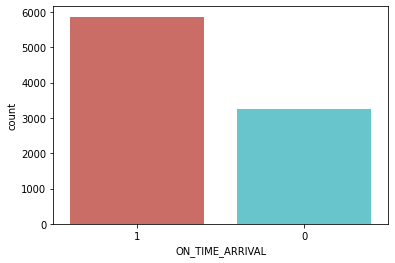

In [10]:
#Investigate suitability of data for cluster analysis
#This data is quite imblanaced
#This will need to be fixed. We correct this a few sections down, but its important to visualize now. 
import seaborn as sns
#CA Model
dfReduced['ON_TIME_ARRIVAL'].value_counts()

sns.countplot(x='ON_TIME_ARRIVAL',data=dfReduced,palette='hls')

#This section scales the variables to values between 0 and 1 in order to get the data ready for logistic regression.
#We only scale variables that aren't already between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
mms = MinMaxScaler()


dfScaled[["DISTANCE","DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]] = mms.fit_transform(dfScaled[["DISTANCE","DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]])


This chart is the visualization of the distribution of our ON_TIME_ARRIVAL variable, which is our variable of interest.  We created this chart to show that we have a data imbalance, and this chart also shows that in general most flights are on time (Coded as a 1 in this dataset).  The reason for this visualization is to see that around 2/3 of the flights are on time, meaning that if you guess that a flight is on time, more often than not you will be correct.

## Check and handle missing data

In [11]:
#Check cols with missing data
print(dfScaled.isnull().sum())

OP_CARRIER             0
ORIGIN                 0
DEP_DELAY              0
ARR_DELAY              0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
MONTH                  0
ON_TIME_ARRIVAL        0
dtype: int64


# Check and handle duplicate data

In [12]:
print(len(dfScaled))
dfScaled.drop_duplicates(keep = False, inplace = True)
print(len(dfScaled))


9132
9132


As you can see above we had 128 duplicates, these were removed as we have so much data that removing 128 records (that are duplicated anyway) has almost no impact on our analysis. 

### Final Dataframe for Analysis

In [13]:
#labeled data
dfReducedUL = dfScaled
dfReducedUL1 = dfScaled
dfReducedUL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9132 entries, 4758016 to 6002955
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OP_CARRIER           9132 non-null   int8   
 1   ORIGIN               9132 non-null   int8   
 2   DEP_DELAY            9132 non-null   float64
 3   ARR_DELAY            9132 non-null   float64
 4   ACTUAL_ELAPSED_TIME  9132 non-null   float64
 5   AIR_TIME             9132 non-null   float64
 6   DISTANCE             9132 non-null   float64
 7   CARRIER_DELAY        9132 non-null   float64
 8   WEATHER_DELAY        9132 non-null   float64
 9   NAS_DELAY            9132 non-null   float64
 10  SECURITY_DELAY       9132 non-null   float64
 11  LATE_AIRCRAFT_DELAY  9132 non-null   float64
 12  MONTH                9132 non-null   int8   
 13  ON_TIME_ARRIVAL      9132 non-null   object 
dtypes: float64(10), int8(3), object(1)
memory usage: 882.9+ KB


At this point we have no missing data and there are also no duplicate rows.

# Meaning and Type of Data

In this section we will describe in detail each of our variables, both variables that were included in the dataset and varaibles that we derived based on other variables.

**Note** All of our varaibles have been scaled.  We will explain these variables as they were originally intended in this section of the analysis.  (ie, we will explain the significance of each of these in their original scale) 

#### DEP_DELAY
This is a float64 variable that contains a floating-point representation of the length of time in minutes that a flight was delayed.  For example 181.0 indicates that a flight left 181 minutes after its CRS (Computer reservation system) departure time.  

#### ACTUAL_ELAPSED_TIME
This is a float64 variable that contains a floating-point representation of the measure of time in minutes of a flight.  This is gate-to-gate time (meaning the timer on this starts once the airplane leaves departure the gate, and stops when the plane arrives at its destination gate.  Many other variables are captured in this window (wheels-on, wheels-off etc). This variable is used to capture total length.  

#### AIR_TIME
This is a float64 variable that contains a floating-point representation of the measure of time in minutes of a flight after the flight leaves the ground and measures until it touches down at the destination airport.  This is a useful measure of how long a flight takes minus the activities on the ground.  This variable also helps in determining ground delays.  


#### DISTANCE
This is a float64 variable that contains a floating-point representation of the distance in miles from the origin to the desination.  This is the distance between airports in miles.  FLights with further distances are associated with longer flight times.  



#### CARRIER_DELAY
This is a categorical variable that indicates if the delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).

#### WEATHER_DELAY
This is a categorical variable that indicates if the delay was due to inclement weather.

#### NAS_DELAY
This is a categotial variable that indicates if they delay was due to the national air system.  An exmaple of this would be if NYC's airspace was congested and departing flights were held at their origin to wait until air space was cleared. 

#### SECURITY DELAY
This is a categorical variable that indicates if the delay was due to a security issue.  This could be a departing flight that requires additional screening of passengers or cargo.

#### LATE_AIRCRAFT_DELAY
This is a categorical variable that indicates if the delay was due to the inbound aircaft arriving late. 

#### ON_TIME_ARRIVAL
This is an indicator variable that is a binary outcome variable.  This variable was derived from ACTUAL_ELAPSED_TIME and AIR_TIME to determine if a flight arrived on time. This variable is removed from the dataset in the final dataframe as to make the data unlabeled. 


#### Operating Carriers
Operating carrier has been one-hot encoded.  This is the operating airline of the flight

AirTran, Alaska, America West, American, American Eagle, Atlantic Southeast, Comair, Continental, Delta, ExpressJet Airlines, Continental Express, Frontier, JetBlue, Mesa Airlines, Northwest,Northwest Airlink SkyWest, Southwest, United, US Airways.  


#### ORIGIN
This is a one-hot encoded variable.  This is the origin airport of the flight.
Atlanta, Denver, Dallas-Fort Worth, John F Kennedy, Las Vegas, Los Angeles, Orlando, Chicago O'hare, Seattle, San Francisco. 

#### MONTH
This is a one-hot encoded variable.
This is a variable that we derived from other variables to condense the date information and investigate seasonal trends.  The months are January-December (01=January,12=December).  We derived this from FLIGHT_DATE
The variables 





# Data Understanding 2

In this section, we will visualize important attributes and provide interpretation for all graphs.

The first plot is a histogram of DEP_DELAY.  This is a cruically important variable as this allows us to visualize the spead of depature delays in minutes.  Based on this histogram we say say that the data is ROUGHLY normal.  We can see that most flights leave on time with very little delay or even slighly early.  This plot also allows us to see the extremes on the tails.  We have some flights that leave quite early, and other flights that are very delayed.

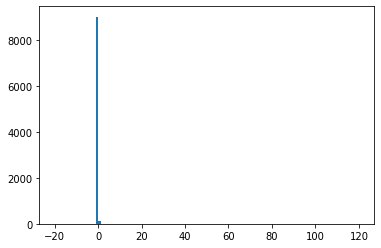

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(carrierDat['DEP_DELAY'], bins=125, range=(-20, 120))
plt.show()

The next plot shows us what should be fairly obvious.  We plot air_time on the x-axis, and distance on the y-axis.  This shows that generally a longer flight (time) means more distance.  This is very true in the general sense, however looking closer to the origin doesn't always tell the same story.

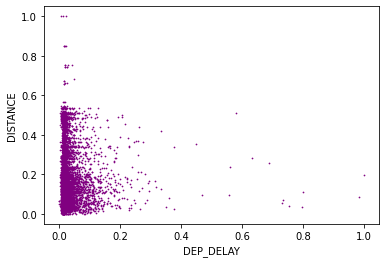

In [15]:
ax1 = carrierDat.plot.scatter(x='DEP_DELAY',y='DISTANCE',c='purple',s=0.5)

The plot below visualizes the different carriers (airlines) against the departure delays.  This shows the trends of certain airlines to have lengthy/and more delays.  We can see that Hawaiian airlines mostly operates on time, while and airline like american airlines has much more disparity between depature delays.  I like this plot because it takes a birds eye perspective of airlines and depature delays.  I think this shows the distinction among airlines that will cancel flights versus airlines that will push through delays.  

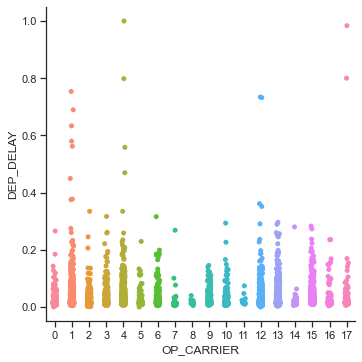

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

sns.catplot(x="OP_CARRIER", y="DEP_DELAY", data=carrierDat)


The chart below tells the same story as the chart above, except this time the chart below shows arrival delay on the y-axis. There are no glaringly obvious trends that differentiate this data from the above, it does appear that there is more spead on arrival delay.  

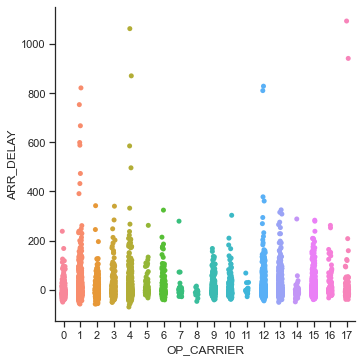

In [17]:
sns.catplot(x="OP_CARRIER", y="ARR_DELAY", data=carrierDat)

The plot below examines depature delays and months during the year.  From this visual, it appears as though month has very little to do with depature delays.  There are certainly months that seem to trend around longer delays, November and June seem to be among the months with longer delays, but this will certainly be worth more investigation.

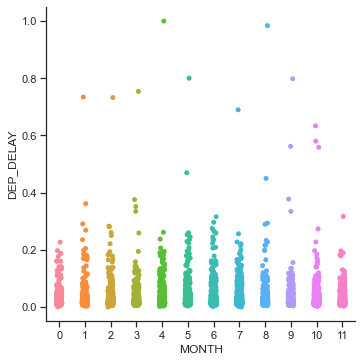

In [18]:
sns.catplot(x="MONTH", y="DEP_DELAY", data=carrierDat)

The chart below tells the same story as the chart above, except it shows arrival delay instead of depature delay. There doesn't appear to be any obvious difference between the two.

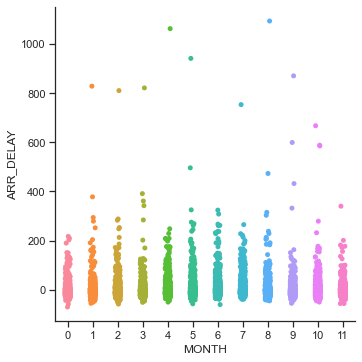

In [19]:
sns.catplot(x="MONTH", y="ARR_DELAY", data=carrierDat)

Below we can examine origin and depature delay.  From the chart below we can see that some airports suffer from greater depature delays, such as Seattle and San Francisco while Orlando seems to have less variability in depature delays.  This could indicate things that cause delays at SFO and SEA are often longer lasting than the things that cause depature delays from Orlando.  

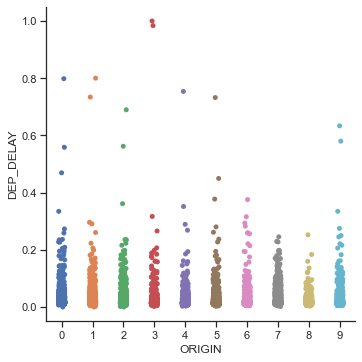

In [20]:
sns.catplot(x="ORIGIN", y="DEP_DELAY", data=carrierDat)

The chart below tells a similar story with SFO and SEA suffering from arrival delays (meaning that SFO and SEA are the origin airports that cause flights arriving elsewhere to be late).  On this plot, we can see that flights originating at LAX seem to better manage arrival delays elsewhere.  This could be due to something like LA's ability to manage lots of depating aircraft at once or something like many runways to allow flights to takeoff in more rapid succession.

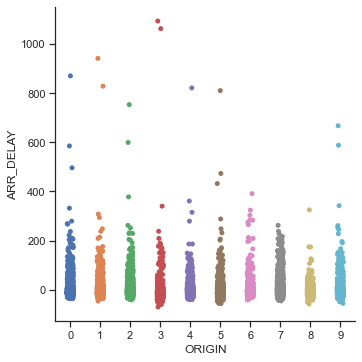

In [21]:
sns.catplot(x="ORIGIN", y="ARR_DELAY", data=carrierDat)

The plot below tells a very interesting story. We can see that the vast majority of flights arrive on time, even if they departe late. Conversely, many flights that have little depature delay still don't arrive on time. There is a multitude of factors that could cause this all the way from long taxi times, to air traffic control routing issues.

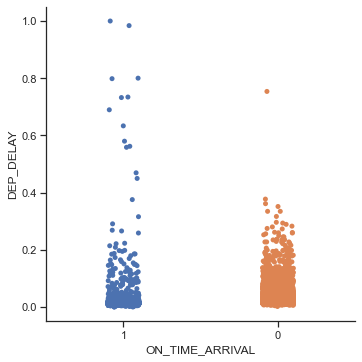

In [22]:
sns.catplot(x="ON_TIME_ARRIVAL", y="DEP_DELAY", data=carrierDat)

# Modeling and Evaluation
Option A: Cluster Analysis


Train and adjust parameters

• Train: Perform cluster analysis using several clustering methods (adjust parameters).

Evaluate and Compare

• Eval: Use internal and/or external validation measures to describe and compare the clusterings and the clusters— how did you determine a suitable number of clusters for each method?

Visualize Results

• Visualize: Use tables/visualization to discuss the found results. Explain each visualization in detail.

Summarize the Ramifications

• Summarize: Describe your results. What findings are the most interesting and why?



# Modeling and Evaluation 1

For this dataset, it probably makes sense to try and cluster AIR_TIME and DISTANCE together because they have similar information and can likely be combined. It is unclear exactly where to make the classes discrete and how many levels we should make, so we will try a few different parameterizations to investigate this.

It also might make sense to make the 'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY' variables into a single discrete variable representing clusters of delays. Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering).

Additionally It also might make sense to make the 'Operating Carrier_9E','Operating Carrier_AA','Operating Carrier_AS','Operating Carrier_B6','Operating Carrier_DL','Operating Carrier_EV','Operating Carrier_F9','Operating Carrier_G4','Operating Carrier_HA','Operating Carrier_MQ','Operating Carrier_NK','Operating Carrier_OH','Operating Carrier_OO','Operating Carrier_UA','Operating Carrier_VX','Operating Carrier_WN','Operating Carrier_YV','Operating Carrier_YX','Origin_ATL','Origin_DEN','Origin_DFW','Origin_JFK','Origin_LAS','Origin_LAX','Origin_MCO','Origin_ORD','Origin_SEA','Origin_SFO' variables into a single discrete variable representing clusters of airlines. Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering).

In [23]:
#put dfReducedUL into new df
rfDat = dfReducedUL

### Baseline Classification Performance
#### We start by performing 10 fold cross validation and using the raw features in a Random Forest classifer. We get the average accuracy of classifying whther a flight arrives on time or not.

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

#Set outcome
y= rfDat['ON_TIME_ARRIVAL']
#remove outcome to prevent snooping
del rfDat['ON_TIME_ARRIVAL']
#Assign predictors
X= rfDat

clf = RandomForestClassifier(n_estimators=150,random_state=rs)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)




Average accuracy =  97.99613412871697 +- 0.5407811400659606


Do some feature engineering. We will start by using kmeans on AIR_TIME and DISTANCE together.

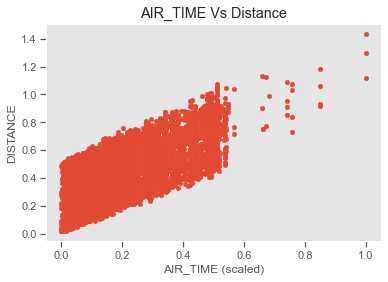

In [25]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = rfDat[['AIR_TIME','DISTANCE']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('AIR_TIME (scaled)'), plt.ylabel('DISTANCE')
plt.grid()
plt.title('AIR_TIME Vs Distance')
plt.show()

In [68]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


distortions = []
inertias = []

X1 = rfDat[['AIR_TIME','DISTANCE']]
K = range(1,10)

for k in K:
    cls = KMeans(n_clusters=k, init='k-means++',random_state=45)
    cls.fit(X1)
    newfeature = cls.labels_ # the labels from kmeans clustering
    distortions.append(sum(np.min(cdist(X1, cls.cluster_centers_, 'euclidean'), axis=1)) / X1.shape[0])
    inertias.append(cls.inertia_)
    X = rfDat[['DEP_DELAY','ACTUAL_ELAPSED_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','ORIGIN','OP_CARRIER','MONTH']]
    X = np.column_stack((X,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=y,cv=cv)

    print ("Average accuracy (with kmeans for AIR_TIME/DISTANCE)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  82.3366950994749 +- 1.1072754904884885
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  82.66530614201383 +- 1.2561837487679341
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.08136065247662 +- 1.2222868383170093
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.12523217996315 +- 1.0595638713265405
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.25654717537347 +- 1.0299471746622897
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.18011652737866 +- 0.950768272884866
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.42088864708884 +- 1.2224304482492727
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.78228649629351 +- 1.1251823967089454
Average accuracy (with kmeans for AIR_TIME/DISTANCE)=  83.57424126583916 +- 1.057409340863251


In [77]:
hopkins(X1, X1.shape[0])

0.003976758140562207

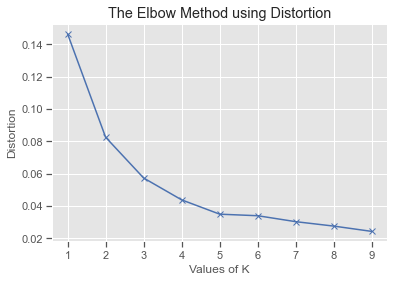

In [69]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

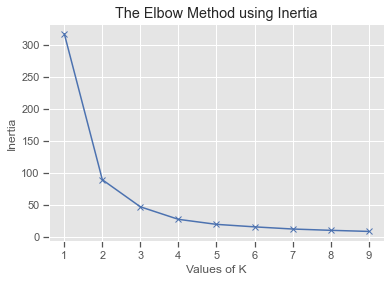

In [70]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

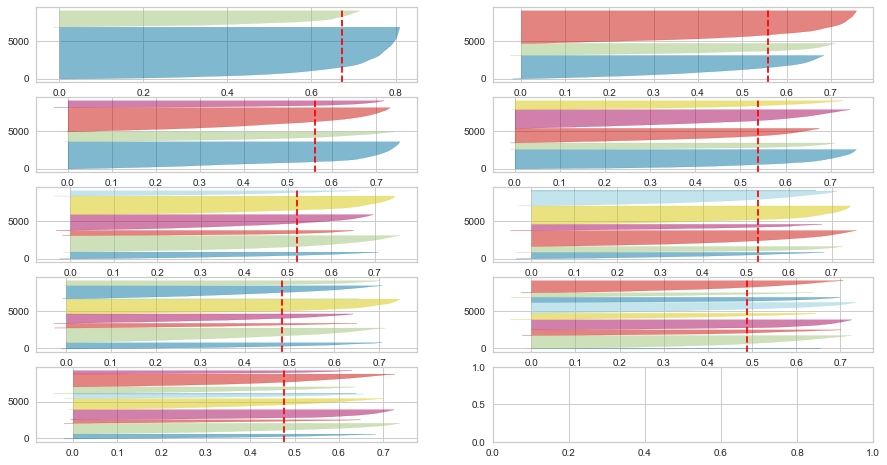

In [92]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(5, 2, figsize=(15,8))
for i in [2, 3, 4, 5,6,7,8,9,10]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X1)

From the results above we can average accuracy of the folds has decreased, but not by much, and the deviation from the mean has increased, but only slightly. 

In [54]:
from sklearn.cluster import KMeans
import numpy as np


distortions = []
inertias = []
X2 = rfDat[['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY']]
K = range(1,10)

for k in K:
    cls = KMeans(n_clusters=k, init='k-means++',random_state=rs)
    cls.fit(X2)
    newfeature = cls.labels_ # the labels from kmeans clustering
    distortions.append(sum(np.min(cdist(X2, cls.cluster_centers_, 'euclidean'), axis=1)) / X2.shape[0])
    inertias.append(cls.inertia_)
    X =  rfDat[['AIR_TIME','DISTANCE','OP_CARRIER','MONTH','ORIGIN']]
    X = np.column_stack((X,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=y,cv=cv)

    print ("Average accuracy (with kmeans for CARRIER_DELAY/WEATHER_DELAY/NAS_DELAY/SECURITY_DELAY/LATE_AIRCRAFT_DELAY/DEP_DELAY)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for CARRIER_DELAY/WEATHER_DELAY/NAS_DELAY/SECURITY_DELAY/LATE_AIRCRAFT_DELAY/DEP_DELAY)=  71.04632574459366 +- 1.5459578944841563
Average accuracy (with kmeans for CARRIER_DELAY/WEATHER_DELAY/NAS_DELAY/SECURITY_DELAY/LATE_AIRCRAFT_DELAY/DEP_DELAY)=  71.04632574459366 +- 1.5459578944841563
Average accuracy (with kmeans for CARRIER_DELAY/WEATHER_DELAY/NAS_DELAY/SECURITY_DELAY/LATE_AIRCRAFT_DELAY/DEP_DELAY)=  71.04632574459366 +- 1.5459578944841563
Average accuracy (with kmeans for CARRIER_DELAY/WEATHER_DELAY/NAS_DELAY/SECURITY_DELAY/LATE_AIRCRAFT_DELAY/DEP_DELAY)=  71.04632574459366 +- 1.5459578944841563


KeyboardInterrupt: 

In [ ]:
hopkins(X2, X2.shape[0])

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [28]:
from sklearn.cluster import KMeans
import numpy as np

X3 = rfDat[['OP_CARRIER','ORIGIN']]
K = range(1,10)
distortions = []
inertias = []

for k in K:
    cls = KMeans(n_clusters=k, init='k-means++',random_state=45)
    cls.fit(X3)
    newfeature = cls.labels_ # the labels from kmeans clustering
    distortions.append(sum(np.min(cdist(X3, cls.cluster_centers_, 'euclidean'), axis=1)) / X3.shape[0])
    inertias.append(cls.inertia_)
    X = rfDat[['AIR_TIME','DISTANCE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY','MONTH']]
    X = np.column_stack((X,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=y,cv=cv)

    print ("Average accuracy (with kmeans for Operating Carrier and Origin)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for Operating Carrier and Origin)=  82.43548692482283 +- 1.2580037552541845


In [ ]:
hopkins(X3, X3.shape[0])

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

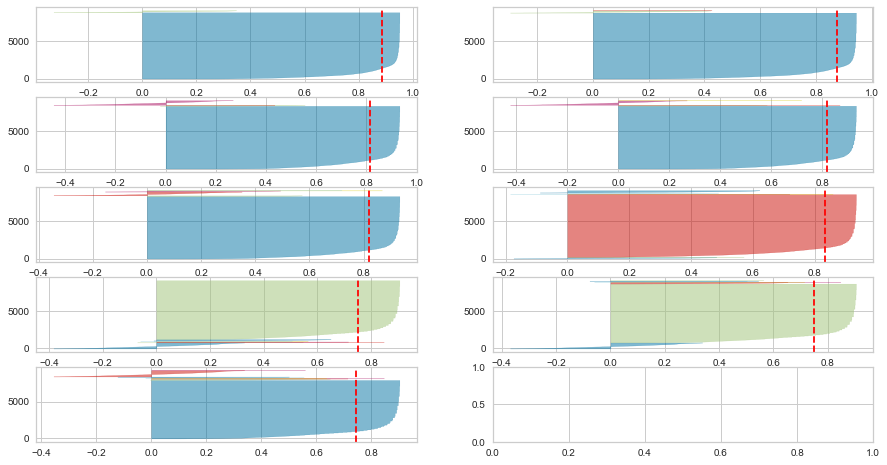

In [93]:
fig, ax = plt.subplots(5, 2, figsize=(15,8))
for i in [2, 3, 4, 5,6,7,8,9,10]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X2)

In [29]:
%%time 

X1 = rfDat[['AIR_TIME','DISTANCE']]
X2 = rfDat[['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY']]
X3 = rfDat[['OP_CARRIER','ORIGIN']]

params = []
for n_dist in range(2,12):
    for n_delay in range(1,20):
           for n_dest in range (1,5):
                # get the first clustering
                cls_dist = KMeans(n_clusters=n_dist, init='k-means++',random_state=rs)
                cls_dist.fit(X1)
                newfeature_fare = cls_dist.labels_ # the labels from kmeans clustering

                # append on the second clustering
                cls_delay = KMeans(n_clusters=n_delay, init='k-means++',random_state=rs)
                cls_delay.fit(X2)
                newfeature_fam = cls_delay.labels_ # the labels from kmeans clustering

                # append on the third clustering
                cls_dest = KMeans(n_clusters=n_dest, init='k-means++',random_state=rs)
                cls_dest.fit(X3)
                newfeature_fare = cls_dest.labels_ # the labels from kmeans clustering
        
        
                X = rfDat
                X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

                acc = cross_val_score(clf,X,y=y,cv=cv)
                params.append((n_dist,n_delay,n_dest,acc.mean()*100,acc.std()*100)) # save state

                print ("Clusters",n_dist,n_delay,n_dest,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 2 1 1 Average accuracy =  98.00708703123615 +- 0.5533796635928617
Clusters 2 1 2 Average accuracy =  98.01803993375533 +- 0.5590849364295244
Clusters 2 1 3 Average accuracy =  97.99613412871697 +- 0.5407811400659606


KeyboardInterrupt: 

It seems that about the best we can do with these new discretization methods is around 83%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable.

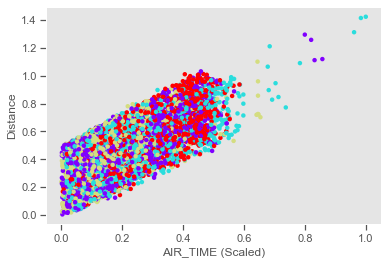

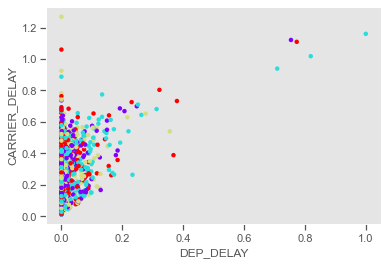

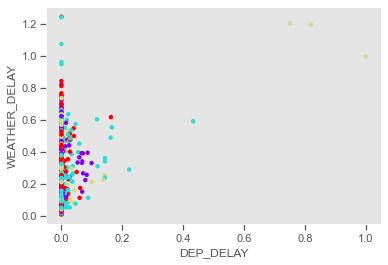

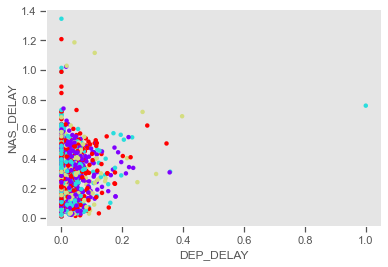

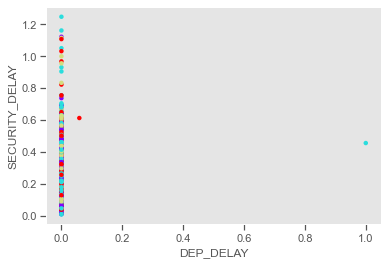

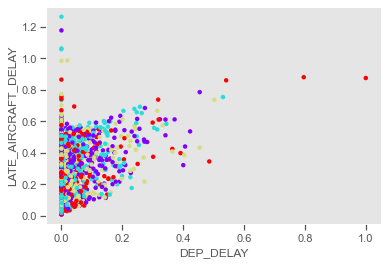

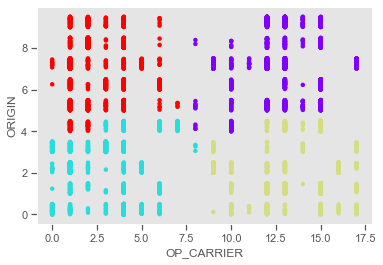

In [30]:
import matplotlib.gridspec as gridspec
n_dist=7
n_delay=17
n_dest =3

X1 = rfDat[['AIR_TIME','DISTANCE']]
X2 = rfDat[['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY']]
X3 = rfDat[['OP_CARRIER','ORIGIN']]


cls_dist = KMeans(n_clusters=n_dist, init='k-means++',random_state=rs)
cls_dist.fit(X1)
newfeature_dist = cls_dist.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_delay = KMeans(n_clusters=n_delay, init='k-means++',random_state=rs)
cls_delay.fit(X2)
newfeature_delay = cls_delay.labels_ # the labels from kmeans clustering

# append on the third clustering
cls_dest = KMeans(n_clusters=n_dest, init='k-means++',random_state=rs)
cls_dest.fit(X3)
newfeature_dest = cls_dest.labels_ # the labels from kmeans clustering

X1=X1.values
plt.figure()
plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('AIR_TIME (Scaled)'), plt.ylabel('Distance')
plt.grid()

X2=X2.values
plt.figure()
plt.scatter(X2[:, 0], X2[:, 5]+np.random.random(X2[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('DEP_DELAY'), plt.ylabel('CARRIER_DELAY')
plt.grid()

plt.figure()
plt.scatter(X2[:, 1], X2[:, 5]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('DEP_DELAY'), plt.ylabel('WEATHER_DELAY')
plt.grid()

plt.figure()
plt.scatter(X2[:, 2], X2[:, 5]+np.random.random(X2[:, 2].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('DEP_DELAY'), plt.ylabel('NAS_DELAY')
plt.grid()

plt.figure()
plt.scatter(X2[:, 3], X2[:, 5]+np.random.random(X2[:, 3].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('DEP_DELAY'), plt.ylabel('SECURITY_DELAY')
plt.grid()

plt.figure()
plt.scatter(X2[:, 4], X2[:, 5]+np.random.random(X2[:, 4].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('DEP_DELAY'), plt.ylabel('LATE_AIRCRAFT_DELAY')
plt.grid()

X3=X3.values
plt.figure()
plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('OP_CARRIER'), plt.ylabel('ORIGIN')
plt.grid()


In [31]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X1 = rfDat[['AIR_TIME','DISTANCE']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_delay in range(1,5):

        # append on the clustering
        cls_delay = AgglomerativeClustering(n_clusters=n_delay, linkage=link)
        cls_delay.fit(X2)
        newfeature_dist = cls_delay.labels_ # the labels from kmeans clustering

       
        X = rfDat
        X = np.column_stack((X,pd.get_dummies(newfeature_dist)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_dist,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_delay,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 1 ward Average accuracy =  97.97422832367864 +- 0.5162888195837134
C= 2 ward Average accuracy =  98.00708703123615 +- 0.5468373502811281
C= 3 ward Average accuracy =  97.99613412871697 +- 0.5646563358732515
C= 4 ward Average accuracy =  98.00707504775418 +- 0.5534479189975674
C= 1 complete Average accuracy =  97.97422832367864 +- 0.5162888195837134
C= 2 complete Average accuracy =  98.01803993375533 +- 0.5590849364295244
C= 3 complete Average accuracy =  97.98518122619781 +- 0.5585785524733045
C= 4 complete Average accuracy =  97.96327542115947 +- 0.5411450851486707
C= 1 average Average accuracy =  97.97422832367864 +- 0.5162888195837134
C= 2 average Average accuracy =  97.99614611219894 +- 0.5384834147407486
C= 3 average Average accuracy =  97.99613412871699 +- 0.570994520164134
C= 4 average Average accuracy =  97.99613412871699 +- 0.570994520164134
CPU times: user 1min 56s, sys: 2.51 s, total: 1min 58s
Wall time: 1min 58s


In [32]:
%%time 

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_delay = DBSCAN(eps=eps, min_samples=mpts)
        cls_delay.fit(X2)
        newfeature_fam = cls_delay.labels_ # the labels from kmeans clustering

        
        X = rfDat
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_delay,acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 5 Average accuracy =  97.98519320967978 +- 0.564937103224726
0.1 6 Average accuracy =  98.00708703123615 +- 0.5555433138379355
0.1 7 Average accuracy =  98.00708703123615 +- 0.5555433138379355
0.125 5 Average accuracy =  97.99613412871697 +- 0.5710128993242923
0.125 6 Average accuracy =  97.99613412871697 +- 0.5710128993242923
0.125 7 Average accuracy =  97.99613412871697 +- 0.5710128993242923
0.15 5 Average accuracy =  97.99613412871699 +- 0.5688896383179973
0.15 6 Average accuracy =  97.99613412871699 +- 0.5688896383179973
0.15 7 Average accuracy =  97.99613412871699 +- 0.5688896383179973
CPU times: user 1min 17s, sys: 3.95 s, total: 1min 21s
Wall time: 1min 21s


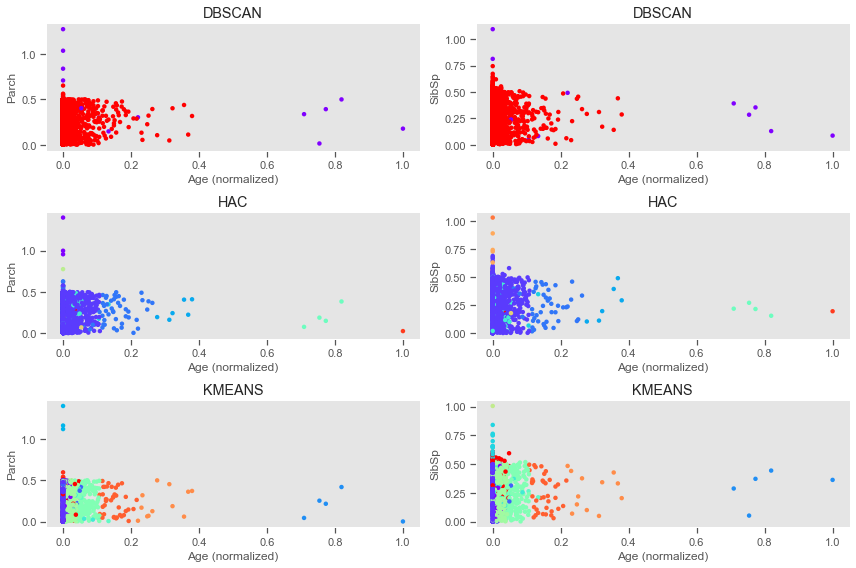

In [33]:
data = X2

cls = DBSCAN(eps=0.125, min_samples=6)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=14, linkage='complete')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=17, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('Parch')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('SibSp')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()

# Agglomerative Clustering

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [35]:
pcaDat=rfDat.sample(n=1000, random_state=45)

In [36]:
X=pcaDat
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [37]:
pca = PCA(n_components = 6)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2','P3','P4','P5','P6']

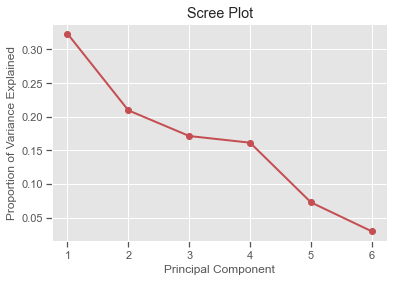

In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [39]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)


Proportion of Variance Explained :  [0.32345416 0.2095707  0.1714407  0.1615345  0.0728586  0.02978476]
Cumulative Prop. Variance Explained:  [0.32345416 0.53302486 0.70446556 0.86600005 0.93885865 0.96864341]


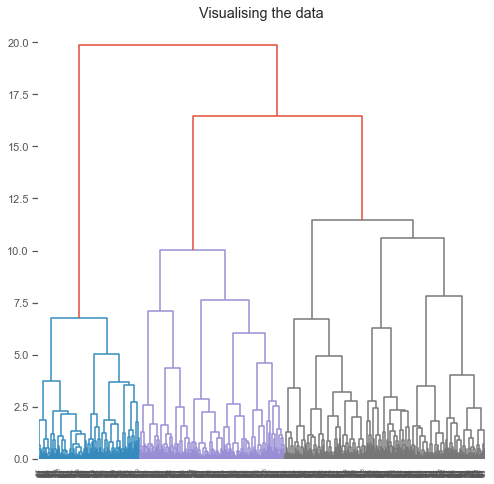

In [40]:
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

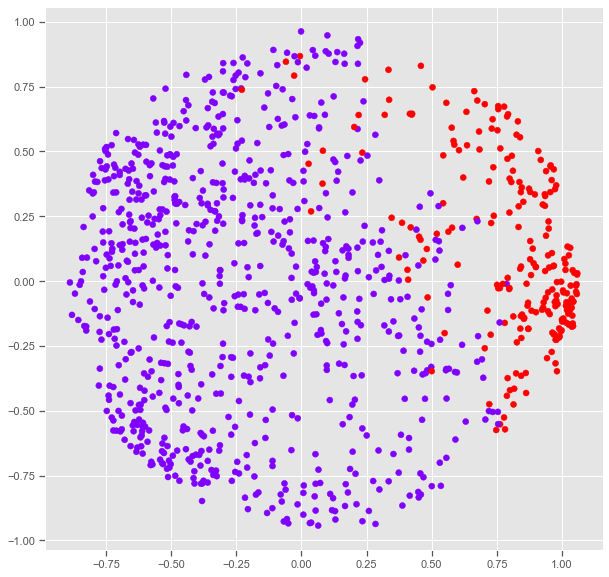

In [41]:

ac2 = AgglomerativeClustering(n_clusters = 2)
  
# Visualizing the clustering
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac2.fit_predict(X_principal), cmap ='rainbow')
plt.show()

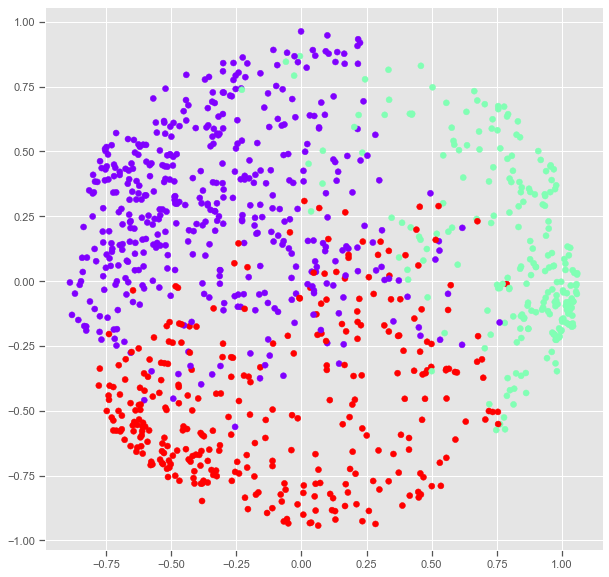

In [42]:
ac3 = AgglomerativeClustering(n_clusters = 3)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = ac3.fit_predict(X_principal), cmap ='rainbow')
plt.show()

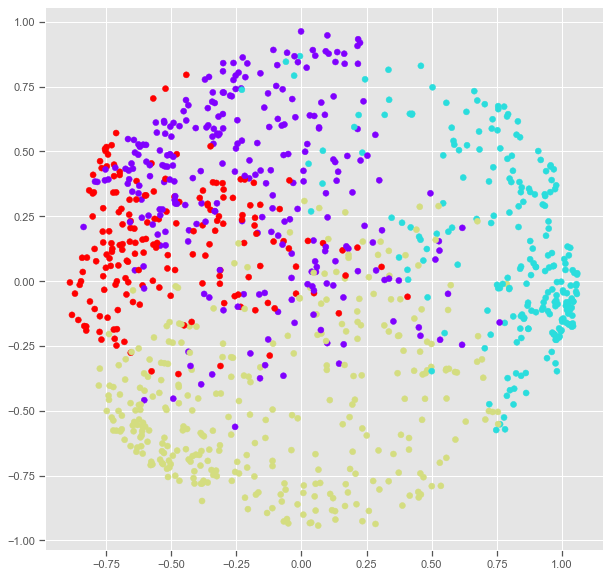

In [43]:
ac4 = AgglomerativeClustering(n_clusters = 4)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac4.fit_predict(X_principal), cmap ='rainbow')
plt.show()

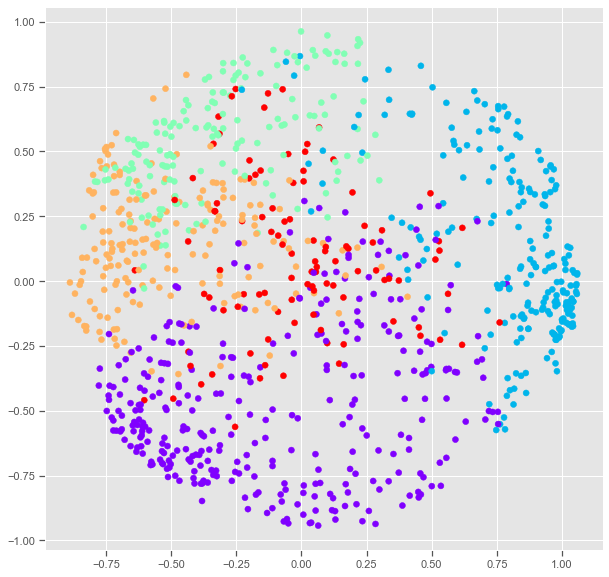

In [44]:
ac5 = AgglomerativeClustering(n_clusters = 5)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac5.fit_predict(X_principal), cmap ='rainbow')
plt.show()

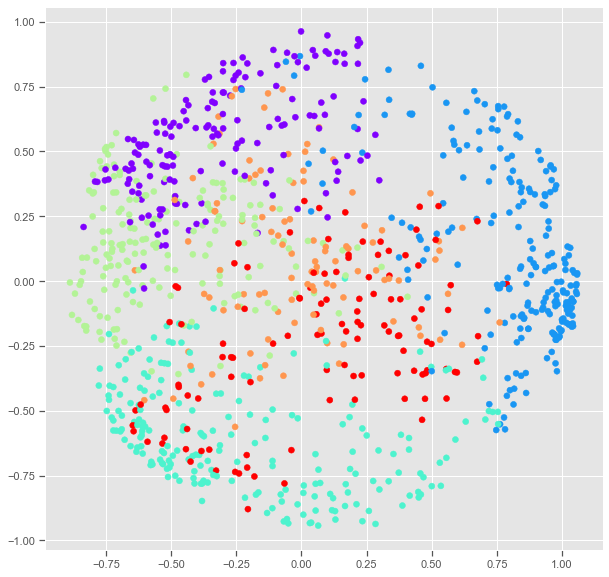

In [45]:
ac6 = AgglomerativeClustering(n_clusters = 6)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac6.fit_predict(X_principal), cmap ='rainbow')
plt.show()

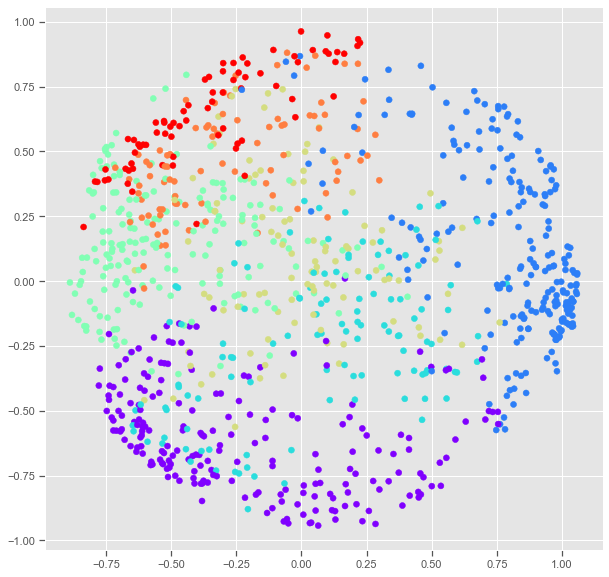

In [46]:

ac7 = AgglomerativeClustering(n_clusters = 7)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac7.fit_predict(X_principal), cmap ='rainbow')
plt.show()

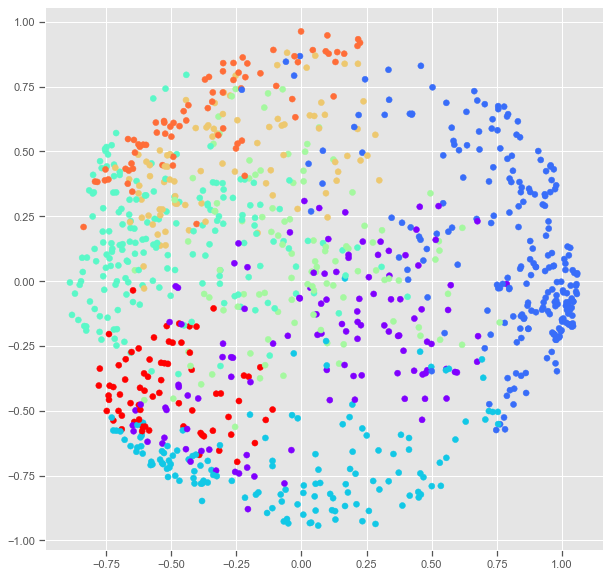

In [47]:

ac8 = AgglomerativeClustering(n_clusters = 8)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac8.fit_predict(X_principal), cmap ='rainbow')
plt.show()

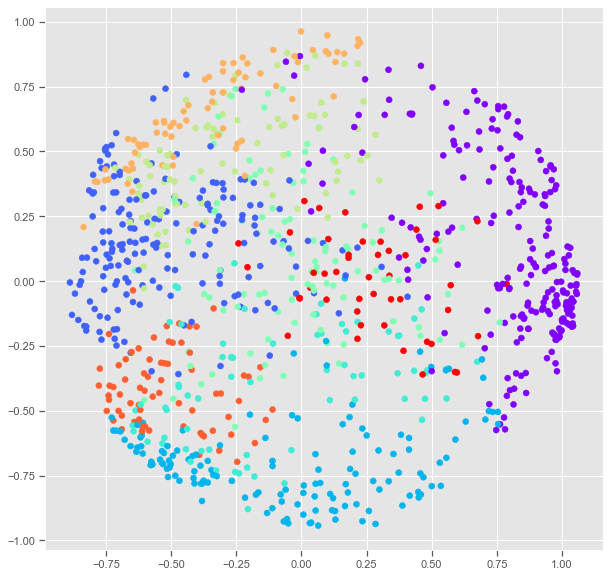

In [48]:

ac9 = AgglomerativeClustering(n_clusters = 9)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac9.fit_predict(X_principal), cmap ='rainbow')
plt.show()

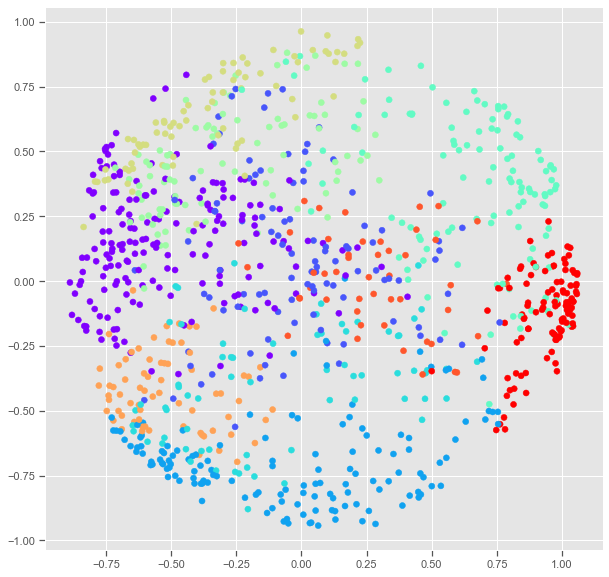

In [49]:

ac10 = AgglomerativeClustering(n_clusters = 10)
  
plt.figure(figsize =(10, 10))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac10.fit_predict(X_principal), cmap ='rainbow')
plt.show()

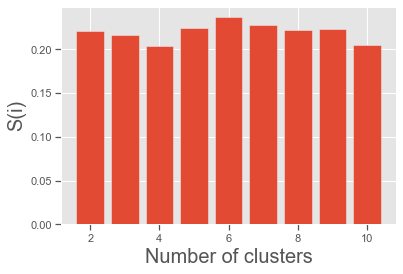

In [50]:
k = [2, 3, 4, 5, 6,7,8,9,10]
  
# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(X_principal, ac2.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac3.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac4.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac5.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac6.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac7.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac8.fit_predict(X_principal)))  
silhouette_scores.append(
        silhouette_score(X_principal, ac9.fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, ac10.fit_predict(X_principal)))
# Plotting a bar graph to compare the results
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

# Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties.

• Did you achieve your goals? If not, can you reign in the utility of your modeling?

• How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?

• How would you deploy your model for interested parties?

• What other data should be collected?

• How often would the model need to be updated, etc.?


# Exceptional Work

Not applicable due to team size